In [15]:
import numpy as np

from DORR_matrix import build_pauli_sum_A_strings, pauli_string_to_matrix, build_matrix_from_paulis

import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from device_var_lse_solver import DeviceVarLSESolver
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator

import numpy as np

from non_dynamical_ansatz import fixed_layered_ansatz
from tqdm import tqdm


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

depth = 10

# As defined by [10]
def TRC_ADA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += d*z
    return trc

def TRC_ASA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*depth
    return trc

In [16]:
for KAPPA in [1.01,10,400]:
    pauli_strings, coeffs, b_state = build_pauli_sum_A_strings(qubits=3, J = 0.1, kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)

    cond = np.linalg.cond(A_mat)
    print(f"alpha = {KAPPA:.4e} -> condition number = {cond:.4e}")

b = np.ones(2**3)
b = b / np.linalg.norm(b)

alpha = 1.0100e+00 -> condition number = 1.0100e+00
alpha = 1.0000e+01 -> condition number = 1.0000e+01
alpha = 4.0000e+02 -> condition number = 4.0000e+02


In [32]:
qubits = 3
n = 2 ** qubits
kappa_list = [10,50,100,200,300,500]


#device = Device(DeviceType.QISKIT_AER, qubits=qubits)
device_noise = Device(DeviceType.QISKIT_AER, qubits=qubits)

save = True
redo_calc = 10


lr = 0.05
threshold = 0.0001
steps = 5000
epochs = 10
abort = 200


results_list_dynamic = np.zeros([redo_calc, n])
results_list_static = np.zeros([redo_calc, n])
results_list_dynamic_noise = np.zeros([redo_calc, n])
results_list_static_noise = np.zeros([redo_calc, n])

TRC_list_dynamic = np.zeros(redo_calc)
TRC_list_static = np.zeros(redo_calc)
TRC_list_dynamic_noise = np.zeros(redo_calc)
TRC_list_static_noise = np.zeros(redo_calc)



depth = 10
param_shape = (qubits + depth*(qubits+qubits -2),)

for KAPPA in kappa_list:
    for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        A, coeffs, b = build_pauli_sum_A_strings(qubits=qubits, J=0.1, kappa=KAPPA)

        ###################################
        #####    DYNAMIC NOISELESS    #####
        ###################################

        lse_dyn_dynamic = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    abort=abort,) 

        solution_local, param_local, it_count_local = lse_dyn_dynamic.solve()
        local_dense_trc = TRC_ASA(it_count_local)
        results_list_dynamic[i, :] = solution_local
        TRC_list_dynamic[i] = local_dense_trc


          
        ###################################
        #####    STATIC  NOISELESS    #####
        ###################################

        lse_stat_static = DeviceVarLSESolver(A,
                    b, 
                    coeffs=coeffs,
                    method='hadamard',
                    ansatz=fixed_layered_ansatz,
                    weights=param_shape,
                    local=True, 
                    lr=lr, 
                    steps=steps,
                    threshold=threshold, 
                    epochs=epochs,
                    abort=abort,)
            

        solution_local, param_local, it_count_local = lse_stat_static.solve()
        results_list_static[i, :] = solution_local
        TRC_list_static[i] = TRC_ADA(it_count_local)


        ###################################
        #####    DYNAMIC NOISE    #####
        ###################################
        lse_dyn_dynamic_noise = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    device=device_noise, 
                    abort=abort,)
        solution_local, param_local, it_count_local = lse_dyn_dynamic_noise.solve()
        local_dense_trc = TRC_ASA(it_count_local)
        results_list_dynamic_noise[i, :] = solution_local
        TRC_list_dynamic_noise[i] = local_dense_trc

        ###################################
        #####    STATIC  NOISE    #####
        ###################################
        lse_stat_static_noise = DeviceVarLSESolver(A,
                    b, 
                    coeffs=coeffs,
                    method='hadamard',
                    ansatz=fixed_layered_ansatz,
                    weights=param_shape,
                    local=True, 
                    lr=lr, 
                    steps=steps,
                    threshold=threshold, 
                    epochs=epochs,
                    device=device_noise,
                    abort=abort,)
        solution_local, param_local, it_count_local = lse_stat_static_noise.solve()
        results_list_static_noise[i, :] = solution_local
        TRC_list_static_noise[i] = TRC_ADA(it_count_local)


        


    if save == True:
        filename = f"data/condition_nr/result_local_condnr_{KAPPA}_w_noise.npz"
        save_dict = {
            'A': A,
            'coeffs': coeffs,
            'b': b,
            'results_list_dynamic': results_list_dynamic,
            'TRC_list_dynamic': TRC_list_dynamic,
            'results_list_static': results_list_static,
            'TRC_list_static': TRC_list_static,
            'results_list_dynamic_noise': results_list_dynamic_noise,
            'TRC_list_dynamic_noise': TRC_list_dynamic_noise,
            'results_list_static_noise': results_list_static_noise,
            'TRC_list_static_noise': TRC_list_static_noise,
            'nr_runs': redo_calc,
            'KAPPA': KAPPA,
            'qubits': qubits,

        }
        np.savez(filename, **save_dict)
        print(f"Saved {filename}")


Run nr. 1/10


Epoch 1/10:   7%|▋         | 359/5000 [00:53<11:28,  6.74it/s, best loss=0.000299, last improvement in step=159, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 301/5000 [00:45<11:47,  6.65it/s, best loss=0.0105, last improvement in step=101, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 79/5000 [00:12<12:36,  6.50it/s, best loss=0.000111, last improvement in step=77, loss=0.000104]
Loss of 0.0000969077 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 277/5000 [00:47<13:28,  5.84it/s, best loss=0.000159, last improvement in step=77, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 279/5000 [00:41<11:42,  6.72it/s, best loss=0.000309, last improvement in step=79, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 303/5000 [00:44<11:27,  6.83it/s, best loss=0.0105, last improvement in step=103, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 174/5000 [00:27<12:31,  6.42it/s, best loss=0.000102, last improvement in step=172, loss=0.000101]
Loss of 0.0000996338 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   7%|▋         | 335/5000 [00:56<13:01,  5.97it/s, best loss=0.00015, last improvement in step=135, loss=0.00015]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:   6%|▌         | 289/5000 [00:42<11:25,  6.88it/s, best loss=0.000304, last improvement in step=89, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 346/5000 [00:51<11:28,  6.76it/s, best loss=0.00993, last improvement in step=146, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 68/5000 [00:10<12:40,  6.49it/s, best loss=0.00011, last improvement in step=67, loss=0.00011]  
Loss of 0.0000979026 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 261/5000 [00:42<12:47,  6.17it/s, best loss=0.000154, last improvement in step=61, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 307/5000 [00:44<11:26,  6.83it/s, best loss=0.000309, last improvement in step=107, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 397/5000 [00:59<11:24,  6.73it/s, best loss=0.0102, last improvement in step=197, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 84/5000 [00:12<12:23,  6.61it/s, best loss=0.000106, last improvement in step=83, loss=0.000106]
Loss of 0.0000996655 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   7%|▋         | 347/5000 [00:56<12:39,  6.12it/s, best loss=0.00015, last improvement in step=147, loss=0.00015]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:   6%|▋         | 321/5000 [00:46<11:22,  6.85it/s, best loss=0.000308, last improvement in step=121, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  15%|█▌        | 760/5000 [01:56<10:51,  6.51it/s, best loss=0.0102, last improvement in step=560, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 67/5000 [00:14<17:15,  4.76it/s, best loss=0.000101, last improvement in step=66, loss=0.000101]
Loss of 0.0000824629 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 300/5000 [00:52<13:43,  5.71it/s, best loss=0.000152, last improvement in step=100, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 303/5000 [00:46<12:04,  6.48it/s, best loss=0.000305, last improvement in step=103, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 297/5000 [00:45<12:04,  6.49it/s, best loss=0.0105, last improvement in step=97, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   9%|▉         | 454/5000 [01:14<12:24,  6.10it/s, best loss=0.000102, last improvement in step=444, loss=0.0001]  
Loss of 0.0000997712 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:51<13:45,  5.70it/s, best loss=0.000158, last improvement in step=92, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:   6%|▋         | 325/5000 [00:50<12:11,  6.39it/s, best loss=0.000301, last improvement in step=125, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  11%|█         | 545/5000 [01:26<11:45,  6.32it/s, best loss=0.0102, last improvement in step=345, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 90/5000 [00:13<12:31,  6.54it/s, best loss=0.000105, last improvement in step=89, loss=0.000105]
Loss of 0.0000997245 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 308/5000 [00:54<13:48,  5.66it/s, best loss=0.000151, last improvement in step=108, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▋         | 316/5000 [00:48<11:59,  6.51it/s, best loss=0.000301, last improvement in step=116, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 300/5000 [00:47<12:18,  6.36it/s, best loss=0.0105, last improvement in step=100, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  10%|█         | 509/5000 [01:17<11:25,  6.55it/s, best loss=0.000106, last improvement in step=501, loss=0.000101]
Loss of 0.0000998970 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 269/5000 [00:46<13:30,  5.84it/s, best loss=0.000154, last improvement in step=69, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:   6%|▌         | 299/5000 [00:46<12:15,  6.39it/s, best loss=0.000302, last improvement in step=99, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 781/5000 [02:03<11:05,  6.34it/s, best loss=0.00993, last improvement in step=581, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 115/5000 [00:19<13:39,  5.96it/s, best loss=0.000106, last improvement in step=105, loss=0.0001]  
Loss of 0.0000997592 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 301/5000 [00:52<13:42,  5.71it/s, best loss=0.000153, last improvement in step=101, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 305/5000 [00:45<11:36,  6.74it/s, best loss=0.000304, last improvement in step=105, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   2%|▏         | 96/5000 [00:14<12:32,  6.51it/s, best loss=0.000102, last improvement in step=95, loss=0.000102]
Loss of 0.0000774480 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:48<13:32,  5.80it/s, best loss=0.000156, last improvement in step=84, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:   6%|▌         | 295/5000 [00:45<12:04,  6.49it/s, best loss=0.000307, last improvement in step=95, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 784/5000 [02:02<10:56,  6.43it/s, best loss=0.0102, last improvement in step=584, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▎         | 125/5000 [00:18<12:14,  6.64it/s, best loss=0.000102, last improvement in step=124, loss=0.000102]
Loss of 0.0000992914 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 263/5000 [00:43<12:57,  6.09it/s, best loss=0.000155, last improvement in step=63, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 293/5000 [00:42<11:24,  6.88it/s, best loss=0.000303, last improvement in step=93, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 306/5000 [00:44<11:29,  6.81it/s, best loss=0.0105, last improvement in step=106, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 290/5000 [00:43<11:53,  6.60it/s, best loss=0.000106, last improvement in step=255, loss=0.0001]  
Loss of 0.0000999941 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 291/5000 [00:48<13:06,  5.99it/s, best loss=0.000159, last improvement in step=91, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:   6%|▌         | 304/5000 [00:44<11:24,  6.86it/s, best loss=0.000303, last improvement in step=104, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  11%|█         | 556/5000 [01:22<11:00,  6.72it/s, best loss=0.0102, last improvement in step=356, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   5%|▍         | 243/5000 [00:38<12:37,  6.28it/s, best loss=0.000105, last improvement in step=233, loss=0.0001]  
Loss of 0.0000998392 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 272/5000 [00:44<12:57,  6.08it/s, best loss=0.000155, last improvement in step=72, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 283/5000 [00:41<11:25,  6.88it/s, best loss=0.000303, last improvement in step=83, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 287/5000 [00:43<11:55,  6.59it/s, best loss=0.0105, last improvement in step=87, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 204/5000 [00:31<12:11,  6.56it/s, best loss=0.000101, last improvement in step=203, loss=0.000101]
Loss of 0.0000999941 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:49<13:44,  5.72it/s, best loss=0.000152, last improvement in step=84, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:   6%|▌         | 283/5000 [00:43<11:58,  6.56it/s, best loss=0.000309, last improvement in step=83, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 417/5000 [01:03<11:40,  6.54it/s, best loss=0.00992, last improvement in step=217, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 91/5000 [00:13<12:19,  6.63it/s, best loss=0.00011, last improvement in step=86, loss=0.0001]   
Loss of 0.0000957576 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 272/5000 [00:45<13:03,  6.03it/s, best loss=0.000159, last improvement in step=72, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 343/5000 [00:50<11:29,  6.75it/s, best loss=0.000304, last improvement in step=143, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  13%|█▎        | 671/5000 [01:40<10:47,  6.69it/s, best loss=0.00993, last improvement in step=471, loss=0.00993]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 150/5000 [00:22<12:22,  6.53it/s, best loss=0.000106, last improvement in step=146, loss=0.000101]
Loss of 0.0000989375 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 283/5000 [00:49<13:39,  5.76it/s, best loss=0.000155, last improvement in step=83, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:   6%|▋         | 316/5000 [00:48<12:02,  6.48it/s, best loss=0.000304, last improvement in step=116, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 297/5000 [00:47<12:29,  6.28it/s, best loss=0.0105, last improvement in step=97, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 128/5000 [00:20<12:53,  6.30it/s, best loss=0.000103, last improvement in step=122, loss=0.0001]  
Loss of 0.0000995115 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 300/5000 [00:51<13:20,  5.87it/s, best loss=0.000153, last improvement in step=100, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 299/5000 [00:45<11:53,  6.59it/s, best loss=0.000303, last improvement in step=99, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 400/5000 [01:00<11:37,  6.59it/s, best loss=0.00993, last improvement in step=200, loss=0.00992]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▎         | 181/5000 [00:27<12:24,  6.47it/s, best loss=0.0001, last improvement in step=180, loss=0.0001]    
Loss of 0.0000992638 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 282/5000 [00:47<13:07,  5.99it/s, best loss=0.000157, last improvement in step=82, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:   6%|▋         | 321/5000 [00:47<11:27,  6.80it/s, best loss=0.000304, last improvement in step=121, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 309/5000 [00:46<11:44,  6.66it/s, best loss=0.0105, last improvement in step=109, loss=0.0105]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 276/5000 [00:42<12:06,  6.50it/s, best loss=0.000102, last improvement in step=273, loss=0.0001]  
Loss of 0.0000997663 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 270/5000 [00:45<13:09,  5.99it/s, best loss=0.000157, last improvement in step=70, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▋         | 320/5000 [00:47<11:29,  6.79it/s, best loss=0.000306, last improvement in step=120, loss=0.000299]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 414/5000 [01:02<11:26,  6.68it/s, best loss=0.0102, last improvement in step=214, loss=0.0102]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  10%|█         | 511/5000 [01:18<11:27,  6.53it/s, best loss=0.000105, last improvement in step=501, loss=0.0001]  
Loss of 0.0000996735 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 280/5000 [00:46<13:09,  5.98it/s, best loss=0.000152, last improvement in step=80, loss=0.00015] 
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_10_w_noise.npz
Run nr. 1/10
Epoch 1/10:   7%|▋         | 332/5000 [00:48<11:27,  6.78it/s, best loss=0.000359, last improvement in step=132, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 597/5000 [01:32<11:25,  6.42it/s, best loss=0.000686, last improvement in step=397, loss=0.000681]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 349/5000 [00:55<12:24,  6.24it/s, best loss=0.000107, last improvement in step=344, loss=0.000101]
Loss of 0.0000999979 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 297/5000 [00:49<13:07,  5.97it/s, best loss=0.000179, last improvement in step=97, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 352/5000 [00:51<11:19,  6.84it/s, best loss=0.000359, last improvement in step=152, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 585/5000 [01:27<10:56,  6.72it/s, best loss=0.000411, last improvement in step=385, loss=0.000404]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 80/5000 [00:12<12:28,  6.57it/s, best loss=0.000102, last improvement in step=79, loss=0.000102]
Loss of 0.0000934419 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 290/5000 [00:48<13:00,  6.03it/s, best loss=0.00018, last improvement in step=90, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:   6%|▌         | 300/5000 [00:44<11:29,  6.82it/s, best loss=0.000362, last improvement in step=100, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 303/5000 [00:45<11:37,  6.73it/s, best loss=0.00097, last improvement in step=103, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 136/5000 [00:20<12:27,  6.51it/s, best loss=0.000105, last improvement in step=130, loss=0.000101]
Loss of 0.0000997833 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 286/5000 [00:47<13:02,  6.02it/s, best loss=0.00018, last improvement in step=86, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▋         | 316/5000 [00:46<11:32,  6.76it/s, best loss=0.000363, last improvement in step=116, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 290/5000 [00:42<11:34,  6.78it/s, best loss=0.000966, last improvement in step=90, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 73/5000 [00:11<12:35,  6.52it/s, best loss=0.000104, last improvement in step=72, loss=0.000104]
Loss of 0.0000960198 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 290/5000 [00:47<12:57,  6.06it/s, best loss=0.000181, last improvement in step=90, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:   6%|▋         | 317/5000 [00:46<11:28,  6.80it/s, best loss=0.00036, last improvement in step=117, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|█         | 505/5000 [01:15<11:10,  6.71it/s, best loss=0.000688, last improvement in step=305, loss=0.000683]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 133/5000 [00:20<12:12,  6.65it/s, best loss=0.000111, last improvement in step=128, loss=0.000101]
Loss of 0.0000992592 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 283/5000 [00:46<12:58,  6.06it/s, best loss=0.000186, last improvement in step=83, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 296/5000 [00:42<11:16,  6.95it/s, best loss=0.000358, last improvement in step=96, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  13%|█▎        | 633/5000 [01:32<10:41,  6.81it/s, best loss=0.000404, last improvement in step=433, loss=0.000401]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 68/5000 [00:10<12:28,  6.59it/s, best loss=0.000104, last improvement in step=67, loss=0.000104]
Loss of 0.0000954648 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 301/5000 [00:49<12:47,  6.12it/s, best loss=0.00018, last improvement in step=101, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:   6%|▌         | 306/5000 [00:45<11:44,  6.66it/s, best loss=0.000359, last improvement in step=106, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 622/5000 [01:32<10:52,  6.71it/s, best loss=0.000692, last improvement in step=422, loss=0.000683]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 78/5000 [00:12<12:37,  6.50it/s, best loss=0.000111, last improvement in step=77, loss=0.000111]
Loss of 0.0000991240 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 299/5000 [00:49<12:54,  6.07it/s, best loss=0.000179, last improvement in step=99, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 286/5000 [00:41<11:30,  6.83it/s, best loss=0.000358, last improvement in step=86, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 301/5000 [00:44<11:40,  6.71it/s, best loss=0.000969, last improvement in step=101, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 102/5000 [00:15<12:29,  6.53it/s, best loss=0.000101, last improvement in step=100, loss=0.000101]
Loss of 0.0000997469 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 289/5000 [00:47<12:56,  6.07it/s, best loss=0.000182, last improvement in step=89, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:   6%|▋         | 317/5000 [00:46<11:26,  6.82it/s, best loss=0.000356, last improvement in step=117, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 304/5000 [00:45<11:42,  6.69it/s, best loss=0.000973, last improvement in step=104, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▋         | 317/5000 [00:48<11:52,  6.57it/s, best loss=0.000103, last improvement in step=313, loss=0.0001]  
Loss of 0.0000996348 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 293/5000 [00:50<13:26,  5.84it/s, best loss=0.00018, last improvement in step=93, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 311/5000 [00:47<12:00,  6.51it/s, best loss=0.000361, last improvement in step=111, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 312/5000 [00:48<12:14,  6.38it/s, best loss=0.000966, last improvement in step=112, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 128/5000 [00:20<12:44,  6.37it/s, best loss=0.000108, last improvement in step=115, loss=0.000101]
Loss of 0.0000999504 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 294/5000 [00:48<12:53,  6.09it/s, best loss=0.000181, last improvement in step=94, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:   7%|▋         | 328/5000 [00:48<11:36,  6.71it/s, best loss=0.000357, last improvement in step=128, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  13%|█▎        | 642/5000 [01:35<10:49,  6.71it/s, best loss=0.000685, last improvement in step=442, loss=0.000683]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 216/5000 [00:33<12:14,  6.51it/s, best loss=0.000111, last improvement in step=207, loss=0.000101]
Loss of 0.0000999919 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 286/5000 [00:46<12:53,  6.09it/s, best loss=0.000178, last improvement in step=86, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 349/5000 [00:51<11:21,  6.83it/s, best loss=0.000355, last improvement in step=149, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 292/5000 [00:43<11:40,  6.72it/s, best loss=0.00097, last improvement in step=92, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 63/5000 [00:09<12:44,  6.45it/s, best loss=0.000138, last improvement in step=62, loss=0.000138]
Loss of 0.0000906149 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 275/5000 [00:45<13:02,  6.04it/s, best loss=0.000184, last improvement in step=75, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:   6%|▋         | 316/5000 [00:45<11:17,  6.92it/s, best loss=0.000356, last improvement in step=116, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 376/5000 [00:55<11:24,  6.76it/s, best loss=0.000403, last improvement in step=176, loss=0.000401]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 135/5000 [00:20<12:20,  6.57it/s, best loss=0.000104, last improvement in step=133, loss=0.000102]
Loss of 0.0000992382 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▍         | 242/5000 [00:39<13:06,  6.05it/s, best loss=0.000185, last improvement in step=42, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 326/5000 [00:47<11:13,  6.94it/s, best loss=0.000364, last improvement in step=126, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 374/5000 [00:54<11:19,  6.81it/s, best loss=0.000404, last improvement in step=174, loss=0.000401]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 69/5000 [00:10<12:28,  6.59it/s, best loss=0.000103, last improvement in step=68, loss=0.000103]
Loss of 0.0000925245 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 288/5000 [00:46<12:43,  6.17it/s, best loss=0.000182, last improvement in step=88, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:   7%|▋         | 340/5000 [00:49<11:15,  6.90it/s, best loss=0.000355, last improvement in step=140, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▌         | 293/5000 [00:43<11:31,  6.81it/s, best loss=0.000969, last improvement in step=93, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 69/5000 [00:10<12:24,  6.62it/s, best loss=0.000109, last improvement in step=68, loss=0.000109]
Loss of 0.0000937246 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:46<12:46,  6.15it/s, best loss=0.000181, last improvement in step=84, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   6%|▌         | 285/5000 [00:41<11:20,  6.93it/s, best loss=0.000364, last improvement in step=85, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 795/5000 [01:57<10:20,  6.78it/s, best loss=0.000414, last improvement in step=595, loss=0.000406]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 201/5000 [00:30<12:01,  6.65it/s, best loss=0.000103, last improvement in step=195, loss=0.0001]  
Loss of 0.0000996240 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   4%|▍         | 214/5000 [00:35<13:04,  6.10it/s, best loss=0.000183, last improvement in step=14, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:   7%|▋         | 343/5000 [00:49<11:10,  6.95it/s, best loss=0.000361, last improvement in step=143, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  23%|██▎       | 1163/5000 [02:51<09:24,  6.79it/s, best loss=0.00041, last improvement in step=963, loss=0.000404]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   1%|▏         | 70/5000 [00:10<12:24,  6.62it/s, best loss=0.000109, last improvement in step=65, loss=0.000103]
Loss of 0.0000951843 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 286/5000 [00:46<12:46,  6.15it/s, best loss=0.000179, last improvement in step=86, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 333/5000 [00:47<11:10,  6.96it/s, best loss=0.000359, last improvement in step=133, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  20%|██        | 1003/5000 [02:27<09:49,  6.78it/s, best loss=0.000414, last improvement in step=803, loss=0.000404]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 153/5000 [00:23<12:09,  6.64it/s, best loss=0.000105, last improvement in step=150, loss=0.000101]
Loss of 0.0000994143 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 276/5000 [00:44<12:48,  6.14it/s, best loss=0.000185, last improvement in step=76, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:   6%|▌         | 295/5000 [00:42<11:16,  6.95it/s, best loss=0.000362, last improvement in step=95, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   6%|▋         | 324/5000 [00:48<11:33,  6.74it/s, best loss=0.000965, last improvement in step=124, loss=0.000965]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   8%|▊         | 425/5000 [01:03<11:22,  6.70it/s, best loss=0.000178, last improvement in step=225, loss=0.000172]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:   2%|▏         | 76/5000 [00:11<12:37,  6.50it/s, best loss=0.000106, last improvement in step=74, loss=0.0001]  
Loss of 0.0000932189 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 271/5000 [00:44<12:53,  6.11it/s, best loss=0.000182, last improvement in step=71, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   7%|▋         | 336/5000 [00:48<11:14,  6.91it/s, best loss=0.000362, last improvement in step=136, loss=0.000355]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|▉         | 485/5000 [01:10<11:00,  6.84it/s, best loss=0.000683, last improvement in step=285, loss=0.000682]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 148/5000 [00:25<13:58,  5.79it/s, best loss=0.000106, last improvement in step=141, loss=0.000101]
Loss of 0.0000997576 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 254/5000 [00:42<13:13,  5.98it/s, best loss=0.000184, last improvement in step=54, loss=0.000178]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_50_w_noise.npz
Run nr. 1/10
Epoch 1/10:   6%|▌         | 310/5000 [00:45<11:30,  6.79it/s, best loss=0.000363, last improvement in step=110, loss=0.000362]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  11%|█         | 540/5000 [01:23<11:27,  6.49it/s, best loss=0.000111, last improvement in step=451, loss=0.000102]


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/cost_function/norm_fn/norm_hadamard.py:26: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

In [21]:
len(b)

16

In [33]:
kappa_list = [1.05,2,10,50]#,10,50,100,200,500]

In [34]:
mean_results_dynamic = np.zeros([len(kappa_list), n])
std_results_dynamic = np.zeros([len(kappa_list), n])
mean_trc_dynamic = np.zeros(len(kappa_list))
std_trc_dynamic = np.zeros(len(kappa_list))

mean_results_static = np.zeros([len(kappa_list), n])
std_results_static = np.zeros([len(kappa_list), n])
mean_trc_static = np.zeros(len(kappa_list))
std_trc_static = np.zeros(len(kappa_list))

mean_results_dynamic_noise = np.zeros([len(kappa_list), n])
std_results_dynamic_noise = np.zeros([len(kappa_list), n])
mean_trc_dynamic_noise = np.zeros(len(kappa_list))
std_trc_dynamic_noise = np.zeros(len(kappa_list))
mean_results_static_noise = np.zeros([len(kappa_list), n])
std_results_static_noise = np.zeros([len(kappa_list), n])
mean_trc_static_noise = np.zeros(len(kappa_list))
std_trc_static_noise = np.zeros(len(kappa_list))


classical_solution = np.zeros([len(kappa_list), n])

for i, KAPPA in enumerate(kappa_list):

    filename = f"data/condition_nr/result_local_condnr_{KAPPA}.npz"
    data = np.load(filename)
    
    A = data['A']
    coeffs = data['coeffs']
    b = data['b']
    results_list_dynamic = data['results_list_dynamic']
    TRC_list_dynamic = data['TRC_list_dynamic']
    results_list_static = data['results_list_static']
    TRC_list_static = data['TRC_list_static']
    nr_runs = data['nr_runs']
    KAPPA = data['KAPPA']
    qubits = data['qubits'] 


    mean_results_dynamic[i, :] = np.mean(results_list_dynamic, axis=0)
    std_results_dynamic[i, :] = np.std(results_list_dynamic, axis=0)/ np.sqrt(nr_runs)
    mean_trc_dynamic[i] = np.mean(TRC_list_dynamic)
    std_trc_dynamic[i] = np.std(TRC_list_dynamic)/ np.sqrt(nr_runs)

    mean_results_static[i, :] = np.mean(results_list_static, axis=0)
    std_results_static[i, :] = np.std(results_list_static, axis=0)/ np.sqrt(nr_runs)
    mean_trc_static[i] = np.mean(TRC_list_static)
    std_trc_static[i] = np.std(TRC_list_static)/ np.sqrt(nr_runs)

    mean_results_dynamic_noise[i, :] = np.mean(results_list_dynamic_noise, axis=0)  
    std_results_dynamic_noise[i, :] = np.std(results_list_dynamic_noise, axis=0)/ np.sqrt(nr_runs)
    mean_trc_dynamic_noise[i] = np.mean(TRC_list_dynamic_noise)
    std_trc_dynamic_noise[i] = np.std(TRC_list_dynamic_noise)/ np.sqrt(nr_runs)

    mean_results_static_noise[i, :] = np.mean(results_list_static_noise, axis=0)
    std_results_static_noise[i, :] = np.std(results_list_static_noise, axis=0)/ np.sqrt(nr_runs)
    mean_trc_static_noise[i] = np.mean(TRC_list_static_noise)
    std_trc_static_noise[i] = np.std(TRC_list_static_noise)/ np.sqrt(nr_runs)

    # compute normalized classical solution for comparison, therefore first re-compose system matrix A
    pauli_strings, coeffs, b = build_pauli_sum_A_strings(qubits=int(qubits), kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)
    x_classical = np.linalg.solve(A_mat, b)
    normalized_classical_solution = np.square(np.abs(x_classical / np.linalg.norm(x_classical)))

    classical_solution[i, :] = normalized_classical_solution



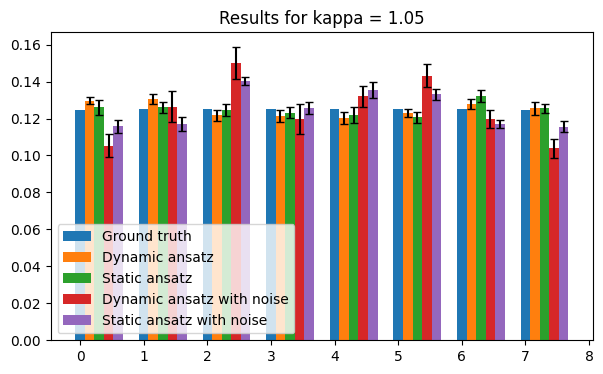

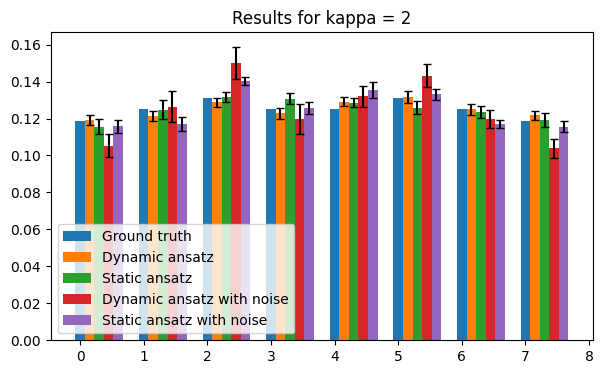

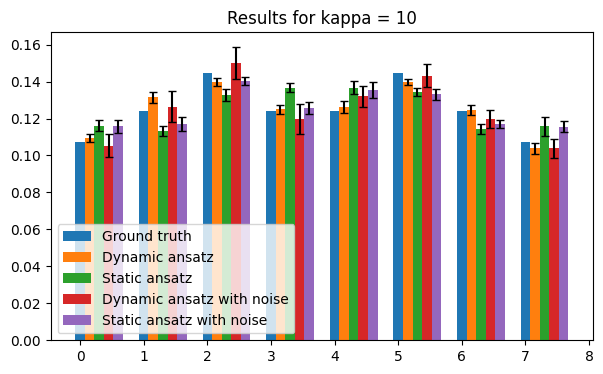

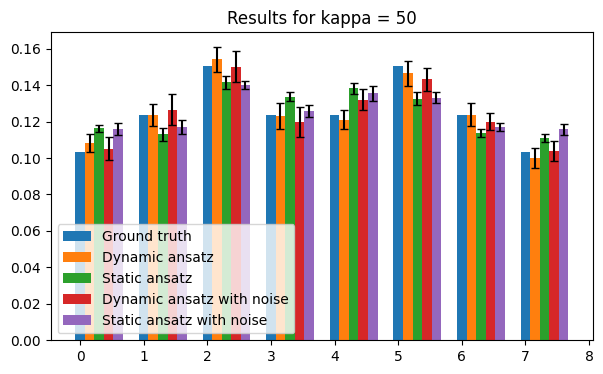

In [35]:
for i, KAPPA in enumerate(kappa_list):

    plt.figure(figsize=(7, 4))
    plt.title(f"Results for kappa = {KAPPA}")

    x = np.arange(len(classical_solution[i, :])) 
    width = 0.15 
    multiplier = 0
    
    plt.bar(x, classical_solution[i, :], width = width, label='Ground truth')
    plt.bar(x + width,  mean_results_dynamic[i, :], yerr=std_results_dynamic[i, :], width=width, capsize=3, label='Dynamic ansatz')
    plt.bar(x + 2*width, mean_results_static[i, :], yerr=std_results_static[i, :], width=width, capsize=3, label='Static ansatz')
    plt.bar(x + 3*width, mean_results_dynamic_noise[i, :], yerr=std_results_dynamic_noise[i, :], width=width, capsize=3, label='Dynamic ansatz with noise')
    plt.bar(x + 4*width, mean_results_static_noise[i, :], yerr=std_results_static_noise[i, :], width=width, capsize=3, label='Static ansatz with noise')
    plt.legend()
    plt.show()